# Прогнозирование температуры звезды

## Описание проекта

Обсерватория «Небо на ладони» предоставлял нам характеристики уже изученных 240 звёзд чтобы с помощью нейросети определять температуру на поверхности обнаруженных звёзд.

Обычно для расчёта температуры учёные пользуются следующими методами:
- Закон смещения Вина.
- Закон Стефана-Больцмана.
- Спектральный анализ.

Каждый из них имеет плюсы и минусы. Обсерватория хочет внедрить технологии машинного обучения для предсказания температуры звёзд, надеясь, что этот метод будет наиболее точным и удобным.

## Цель исследования

Определять температуру на поверхности обнаруженных звёзд с помощью нейросети. 

## Ход исследования

- Подгатовка данных: Загрузка и изучение общей информации из предоставлено датасета.
- Предоработка данных: Обработка пропущенных значений, корректировка типа данных, дубликатов и других аномалий.
- Исследовательский анализ данных: Изучение основных параметров объектов, их распределение, присутствие выбросов,  явление и обработка аномали
- Анализ коррелации: Исследование связи между признаками чтобы понимать если нужно или нет установить несколко признаков
- Построение нейронной сети как 'baseline' чтобы определять температуру 
- Улучшение нейронной сети и метрики RMSE

# Подгатовка данных

## Установка и загрузка модуля

In [1]:
# Установим "руками" модули
!pip install phik -q

In [2]:
# библиотеки

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import phik
from math import ceil
import torch
import torch.nn as nn

from scipy.stats import zscore

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline


from sklearn.metrics import r2_score, root_mean_squared_error, mean_squared_error, mean_absolute_error

## Закрузка датафрейм

In [3]:
df = pd.read_csv('./6_class.csv', usecols= [1, 2, 3, 4, 5, 6])
df.head()

,Temperature (K),Luminosity(L/Lo),Radius(R/Ro),Absolute magnitude(Mv),Star type,Star color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


## Изучение датафрейм

In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 240 entries, 0 to 239
Data columns (total 6 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   Temperature (K)         240 non-null    int64  
 1   Luminosity(L/Lo)        240 non-null    float64
 2   Radius(R/Ro)            240 non-null    float64
 3   Absolute magnitude(Mv)  240 non-null    float64
 4   Star type               240 non-null    int64  
 5   Star color              240 non-null    object 
dtypes: float64(3), int64(2), object(1)
memory usage: 11.4+ KB


Датафрейм содержит 240 обьекты и 7 стольбцы, 
4 количественные признаки:
- Temperature (K), температура на поверхности обнаруженных звёзд в Келвинах,
- Luminosity(L/Lo), относительная светимость L/Lo — светимость звезды относительно Солнца,
- Radius(R/Ro), относительный радиус R/Ro — радиус звезды относительно радиуса Солнца,
- Absolute magnitude(Mv), абсолютная звёздная величина Mv — физическая величина, характеризующая блеск звезды.

3 категоряльние признаки:
- Unnamed: 0, номер свёзды, которы мы будем убрать так как наверно он одинаковы с индексами датафреймы
- Star color, звёздный цвет (white, red, blue, yellow, yellow-orange и др.) — цвет звезды, который определяют на основе спектрального анализа,
- Star type, тип звезды.

Мы видим, что пропущенных значений нет.

## Преобразование заголовка столбца в змеиный регистр

In [5]:
df.columns = [x[0].lower()+x[1:] for x in df.columns]
df.columns = df.columns.str.replace(' ', '_', regex=True)
df.columns = df.columns.str.replace('\(', '_', regex=True)
df.columns = df.columns.str.replace('\)', '', regex=True)
df.columns = df.columns.str.replace('\/', '_', regex=True)
df.columns = df.columns.str.replace('__', '_', regex=True)

In [6]:
df.head()

,temperature_K,luminosity_L_Lo,radius_R_Ro,absolute_magnitude_Mv,star_type,star_color
0,3068,0.002400,0.1700,16.12,0,Red
1,3042,0.000500,0.1542,16.60,0,Red
2,2600,0.000300,0.1020,18.70,0,Red
3,2800,0.000200,0.1600,16.65,0,Red
4,1939,0.000138,0.1030,20.06,0,Red


## Пропуски

Как мы видели ранее с методом info(), в датафрейме нет пропущенных значений.

## Дубликаты

### Явные дубликаты

In [7]:
df.duplicated().sum()

0

Явных дубликатов нет.

### Неявные дубликаты

In [8]:
df['star_color'].value_counts()

star_color
Red                   112
Blue                   55
Blue-white             26
Blue White             10
yellow-white            8
White                   7
Blue white              3
Yellowish White         3
white                   3
Whitish                 2
Orange                  2
yellowish               2
Pale yellow orange      1
White-Yellow            1
Blue                    1
Yellowish               1
Orange-Red              1
Blue white              1
Blue-White              1
Name: count, dtype: int64

In [9]:
df.query('star_color=="yellowish"')['temperature_K']

91    4526
92    4077
Name: temperature_K, dtype: int64

In [10]:
df.query('star_color=="Orange"')['temperature_K']

53     3749
172    4287
Name: temperature_K, dtype: int64

Согласно https://en.wikipedia.org/wiki/Stellar_classification, существует две разные палитры для звездной классификации: Vega-relative chromaticity и Chromaticity (D65).
Мы видим здесь что они смешали две шкалы.
Мы тоже видели что иногда исползовали '-' иногда пробел, иногда исползовали lower case  иногда upper case.

In [11]:
harvard_classification ={
    'Vega-relative chromaticity':['blue', 'bluish white', 'white', 'yellowish white', 'yellow', 'light orange', \
                                 'orangish red'],
    'Chromaticity (D65)': ['blue', 'deep bluish white', 'bluish white', 'white', 'yellowish white',\
                           'pale yellowish orange', 'light orangish red'],
    'index_stell' : ['O', 'B', 'A', 'F', 'G', 'K', 'M'],
    'Effective temperature': ['≥ 33,000 K', '10,000–33,000 K', '7,300–10,000 K', '6,000–7,300 K', \
                              '5,300–6,000 K', '3,900–5,300 K', '2,300–3,900 K']
}

harvard_classification = pd.DataFrame.from_dict(harvard_classification, orient='index').T\
                            .set_index('index_stell')
harvard_classification

,Vega-relative chromaticity,Chromaticity (D65),Effective temperature
index_stell,,,
O,blue,blue,"≥ 33,000 K"
B,bluish white,deep bluish white,"10,000–33,000 K"
A,white,bluish white,"7,300–10,000 K"
F,yellowish white,white,"6,000–7,300 K"
G,yellow,yellowish white,"5,300–6,000 K"
K,light orange,pale yellowish orange,"3,900–5,300 K"
M,orangish red,light orangish red,"2,300–3,900 K"


In [12]:
# Исправление названии цвета
df['star_color'] = df['star_color'].str.lower()
df['star_color'] = df['star_color'].str.rstrip()
df['star_color'] = df['star_color'].str.replace(' ', '-')
df['star_color'] = df['star_color'].str.replace('pale-yellow-orange', 'K')
df['star_color'] = df['star_color'].str.replace('blue-white', 'B')
df['star_color'] = df['star_color'].str.replace('blue', 'O')
df['star_color'] = df['star_color'].str.replace('yellowish', 'yellow')
df['star_color'] = df['star_color'].str.replace('yellow-white', 'F')
df['star_color'] = df['star_color'].str.replace('white-yellow', 'F')
df['star_color'] = df['star_color'].str.replace('yellow', 'G')
df['star_color'] = df['star_color'].str.replace('whitish', 'white')
df['star_color'] = df['star_color'].str.replace('white', 'A')
df['star_color'] = df['star_color'].str.replace('orange-red', 'M')
df['star_color'] = df['star_color'].str.replace('orange', 'K')
df['star_color'] = df['star_color'].str.replace('red', 'M')

In [13]:
df['star_color'].value_counts()

star_color
M    113
O     56
B     41
A     12
F     12
K      3
G      3
Name: count, dtype: int64

In [14]:
pivot_temp = df.pivot_table(index='star_color', values='temperature_K', aggfunc=['min', 'max'])
pivot_temp.columns = ['min_temp', 'max_temp']
pivot_temp.sort_values(by='max_temp', ascending=False)

,min_temp,max_temp
star_color,,
O,5752,40000
B,8570,30000
A,7220,14732
F,5300,12990
K,3749,7230
M,1939,6850
G,4077,4980


Замечаем что диапазон температуры сосвсем не совпадаеть с реальным диапазоном (harvard_classification).

In [15]:
def colour(row):
    if row['temperature_K'] < 3900:
        return 'M'
    elif row['temperature_K'] < 5300 and row['temperature_K'] >= 3900:
        return 'K'
    elif row['temperature_K'] < 6000 and row['temperature_K'] >= 5300:
        return 'G'
    elif row['temperature_K'] < 7300 and row['temperature_K'] >= 6000:
        return 'F'
    elif row['temperature_K'] < 10000 and row['temperature_K'] >= 7300:
        return 'A'
    elif row['temperature_K'] < 33000 and row['temperature_K'] >= 10000:
        return 'B'
    elif row['temperature_K'] >= 33000:
        return 'O'    
df['star_color_real'] = df.apply(colour, axis=1)

In [16]:
def wrong_col(row):
    if row['star_color'] == row['star_color_real']:
        return 0
    else:
        return 1
df['wrong_color'] = df.apply(wrong_col, axis=1)

In [17]:
df['wrong_color'].sum()

72

В датафрейм - 72 старта с неправильным цветом. Мы воспользуемся предоставленными нами данными, а также будем использовать нейронную сеть с реальными значениями цветов для сравнении.

In [18]:
pivot_temp = df.pivot_table(index='star_color', values=['temperature_K','wrong_color'], \
                            aggfunc={'temperature_K':['min', 'max'],'wrong_color':['count', \
                                                                                   lambda x: x.sum()/x.count()] })
pivot_temp.columns = ['max_temp', 'min_temp','share_misclassified_stars', 'nb_stars']
pivot_temp.sort_values(by='max_temp', ascending=False)

,max_temp,min_temp,share_misclassified_stars,nb_stars
star_color,,,,
O,40000,5752,0.803571,56
B,30000,8570,0.146341,41
A,14732,7220,0.333333,12
F,12990,5300,0.750000,12
K,7230,3749,0.666667,3
M,6850,1939,0.026549,113
G,4980,4077,1.000000,3


Из таблицы выше мы ясно видим, что для категории О с 56 звездами 80% из них могут быть ошибочно классифицированы. 80% из них, вероятно, должны быть сине-белыми, а не синими. 
С помощью Гарвардской классификации мы увидели, что цвет тесно связан с температурой. Звезда с высокой температурой по спектральным меркам видится синей (сине-фиолетовой), а когда температура ниже примерно 30000 К, звезда становится белее.
В других категориях также могут быть ошибочно классифицированные звезды, но их ошибочная классификация может быть не такой эффективной, как для категории O.

In [19]:
df = df.drop('wrong_color', axis=1)

## Вывод

После удаления дублирующего столбца (номер звезд), сейчас датафрейм, содержет 6 столбцов, 4 числовых и 2 категориальных. 

Преобразуйте имена столбцов в форме питоны.

У нас нет пропуксов и явны дубликатов.

Мы исправили неявные дубликаты в столбце 'star_color'. Мы также заметили, что можеть быть 72 звезды не имеют цвета, соответствующего их температуре, особенно в категори O и это может испортить нашу модель.

# Исследовательский анализ данных

## Статистический анализ

In [20]:
df_stat = df.drop('star_type', axis=1).describe()
df_stat

,temperature_K,luminosity_L_Lo,radius_R_Ro,absolute_magnitude_Mv
count,240.000000,240.000000,240.000000,240.000000
mean,10497.462500,107188.361635,237.157781,4.382396
std,9552.425037,179432.244940,517.155763,10.532512
min,1939.000000,0.000080,0.008400,-11.920000
25%,3344.250000,0.000865,0.102750,-6.232500
50%,5776.000000,0.070500,0.762500,8.313000
75%,15055.500000,198050.000000,42.750000,13.697500
max,40000.000000,849420.000000,1948.500000,20.060000


Диапазон температур от 1939 К до 40000 Кельвинов. 50% звёздов имеет температуру ниже 5776 К которы почти температура сольнцы (5772 К), а средняя температура составляет 10 497 К. 

Более 50 % звезд в датафрейме меньше Солнца и имеют меньшую светимость, чем оно (среднее значение 0,070500 для относительной светимости, 0,762500 для относительного радиуса).

Согласно вики-странице абсолютной величины, последняя находится в диапазоне от -11 до 20 Мв, диапазон, который указан в нашей статистической таблице.

По данным https://www.sciencefocus.com/space/largest-stars-in-the-universe, радиус 10 крупнейших звезд во R/Ro варьируется от 1374 до 1708 раз большего солнечного радиуса. Здесь у нас 17 звезд с радиусом больше 1374 R/Ro. Являются ли некоторые из них аномалиями?

In [21]:
len(df.query('radius_R_Ro > 1373'))

18

В датафрейме ниже мы также можем видеть, что большие звезды не обязательно означают высокую температуру.

In [22]:
df.query('radius_R_Ro > 1373').sort_values(by='radius_R_Ro')

,temperature_K,luminosity_L_Lo,radius_R_Ro,absolute_magnitude_Mv,star_type,star_color,star_color_real
171,3500,138000.0,1420.0,-8.18,5,M,M
237,8829,537493.0,1423.0,-10.73,5,A,A
118,6850,229000.0,1467.0,-10.07,5,M,F
170,3570,320000.0,1480.0,-7.58,5,M,M
113,3399,117000.0,1486.0,-10.92,5,M,M
230,24145,382993.0,1494.0,-8.84,5,B,B
50,3490,270000.0,1520.0,-9.40,5,M,M
114,3610,132000.0,1522.0,-10.86,5,M,M
116,4015,282000.0,1534.0,-11.39,5,M,K
59,3535,195000.0,1546.0,-11.36,5,M,M


Мы видим, у около половины обьектов датафрейма имеют температуру, радиус и светимость хуже, чем у Солнца.

## Ящик с усами

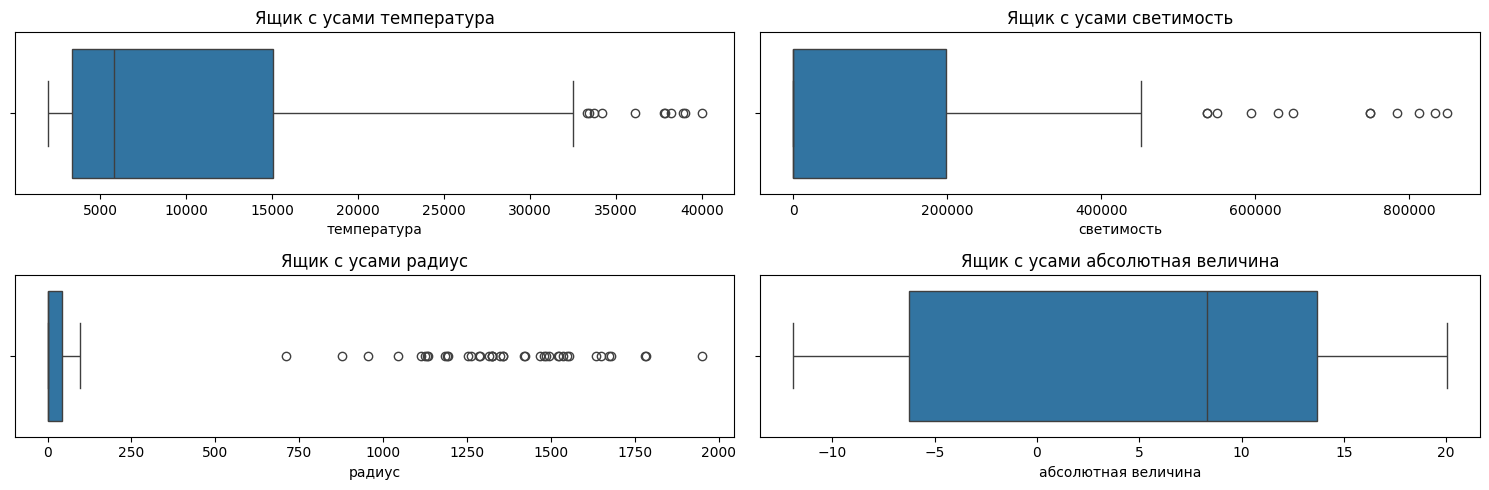

In [23]:
col_num = df.drop('star_type', axis=1).select_dtypes(exclude='object').columns.to_list()

fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(15, 5))

axes = axes.flatten()

columns_names = ['температура', 'светимость', 'радиус', 'абсолютная величина']

for i, column in enumerate(df[col_num].columns):
    
    sns.boxplot(data=df, x=column, ax=axes[i]) 
    
    axes[i].set_title(f'Ящик с усами {columns_names[i]}') 
    axes[i].set_xlabel(f'{columns_names[i]}')

plt.tight_layout()


plt.show()

В датафрейме есть много выбросов, за исключением абсолютной величины. Эти выбросы означают, соответственно, радиус, светимость и температуру, что у нас есть звезды, которые намного больше Солнца, некоторые из них намного ярче Солнца, а некоторые имеют действительно огромную температуру по сравнению с большинством звезд.

## Распределение числовых признаков

### Температура

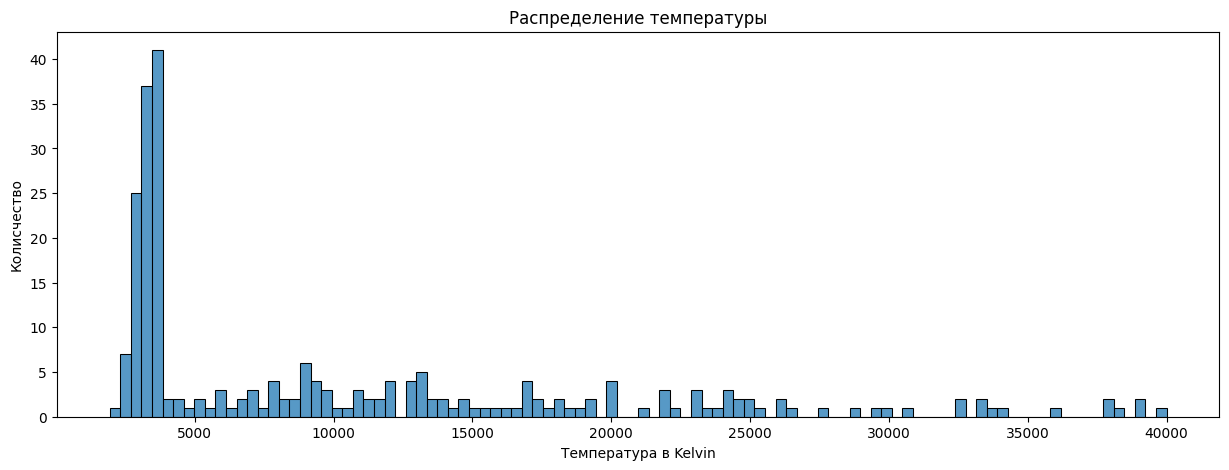

In [24]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.histplot(data=df, x='temperature_K', bins=100);
axes.set_title(f'Распределение температуры') 
axes.set_xlabel('Температура в Kelvin');
axes.set_ylabel('Колисчество');

In [25]:
len(df.query('temperature_K < 4772'))/len(df)

0.4791666666666667

Мы видим, что существует большое количество звезд, у которых температура ниже 4000 К, и что у 47,9% обеьктов температура ниже чем у Солнца. 

### Светимость

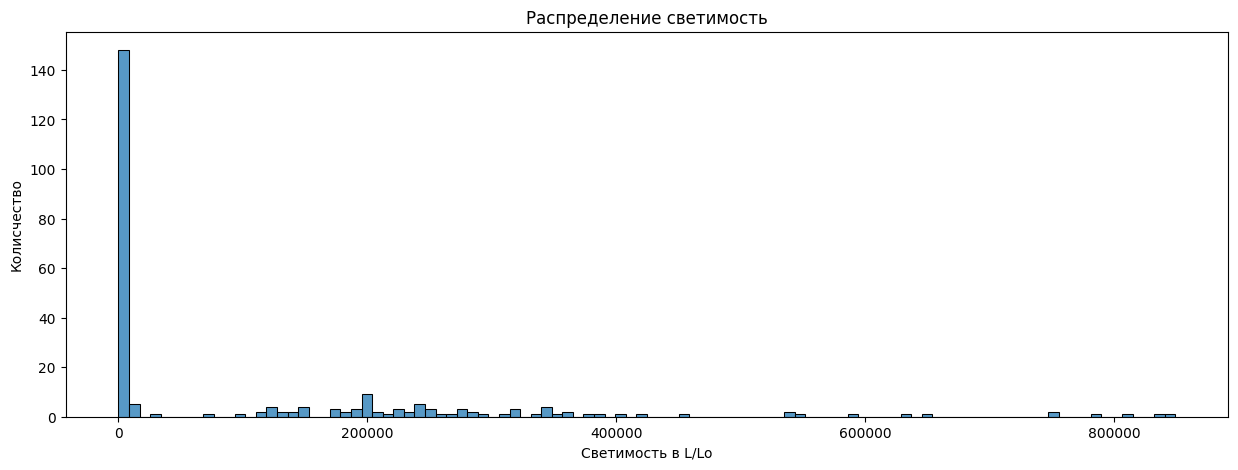

In [26]:
fig, axes = plt.subplots(figsize=(15, 5))
sns.histplot(data=df, x='luminosity_L_Lo', bins=100)
axes.set_title(f'Распределение светимость') 
axes.set_xlabel('Светимость в L/Lo');
axes.set_ylabel('Колисчество');

In [27]:
len(df.query('luminosity_L_Lo < 1'))/len(df)

0.5291666666666667

53% обектов датафрейма имеет меншее светимость сольнца.

### Радиус

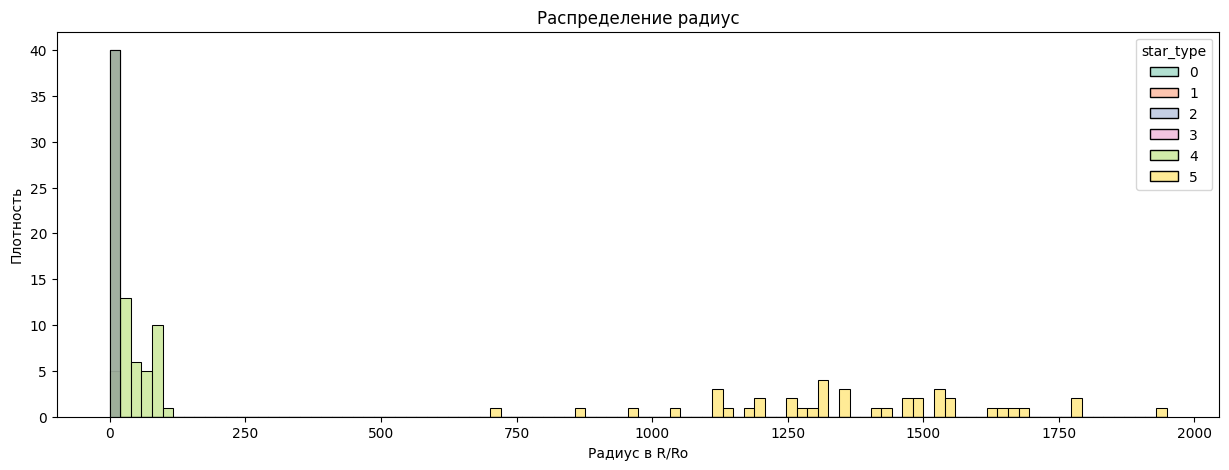

In [28]:
fig, axes = plt.subplots(figsize=(15, 5))

#sns.kdeplot(data=df, x='radius_R/Ro');
sns.histplot(data=df, x='radius_R_Ro', bins=100, hue='star_type', palette='Set2');
axes.set_title(f'Распределение радиус') 
axes.set_xlabel('Радиус в R/Ro');
axes.set_ylabel('Плотность');

In [29]:
len(df[df['radius_R_Ro'] <1])/len(df)

0.5291666666666667

53% обектов датафрейма имеет меншее светимость сольнца. 

Похоже, размер и тип звезды соответствуют.

### Абсолютная величина

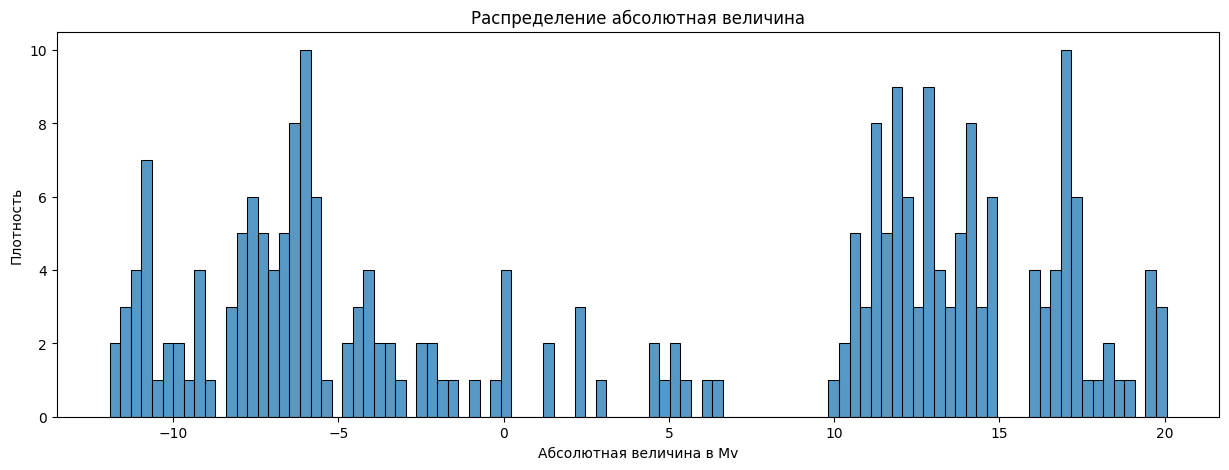

In [30]:
fig, axes = plt.subplots(figsize=(15, 5))
#sns.kdeplot(data=df, x='absolute_magnitude_Mv');
sns.histplot(data=df, x='absolute_magnitude_Mv', bins=100);
axes.set_title(f'Распределение абсолютная величина') 
axes.set_xlabel('Абсолютная величина в Mv');
axes.set_ylabel('Плотность');

У нас что то как биномиальное распределение, и между [-10, 5] и [5, 20] Mv много звезд.

## Distribution of categorical features

### Типа свёзды

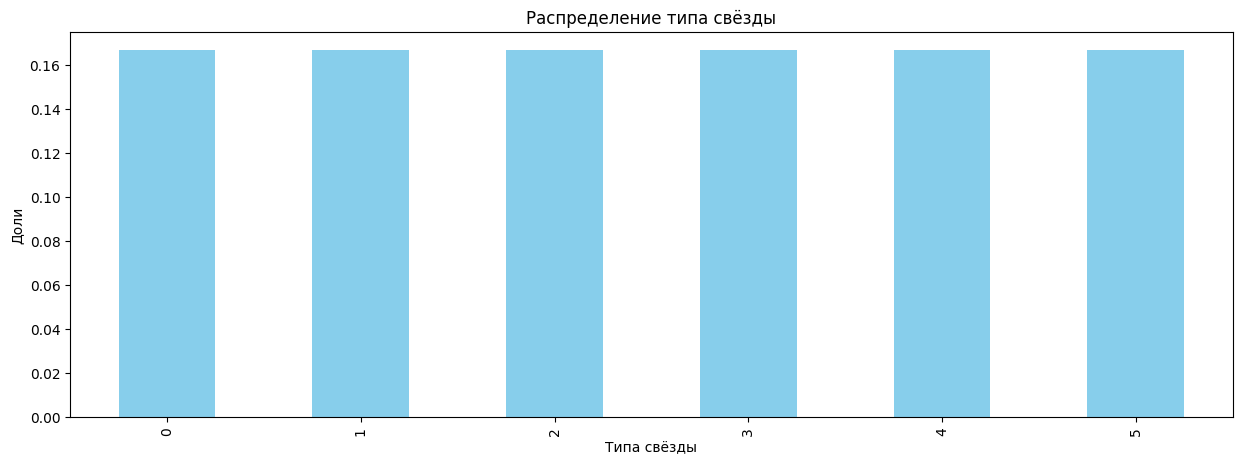

In [31]:
fig, axes = plt.subplots(figsize=(15, 5))
    
df['star_type'].value_counts(normalize=True).plot.bar(color=['skyblue']);

axes.set_title(f'Распределение типа свёзды');
    
axes.set_xlabel('Типа свёзды');
axes.set_ylabel('Доли');


Каждый тип звезд получил одинаковую долю в датафрейме.

### Цвет Звёзды

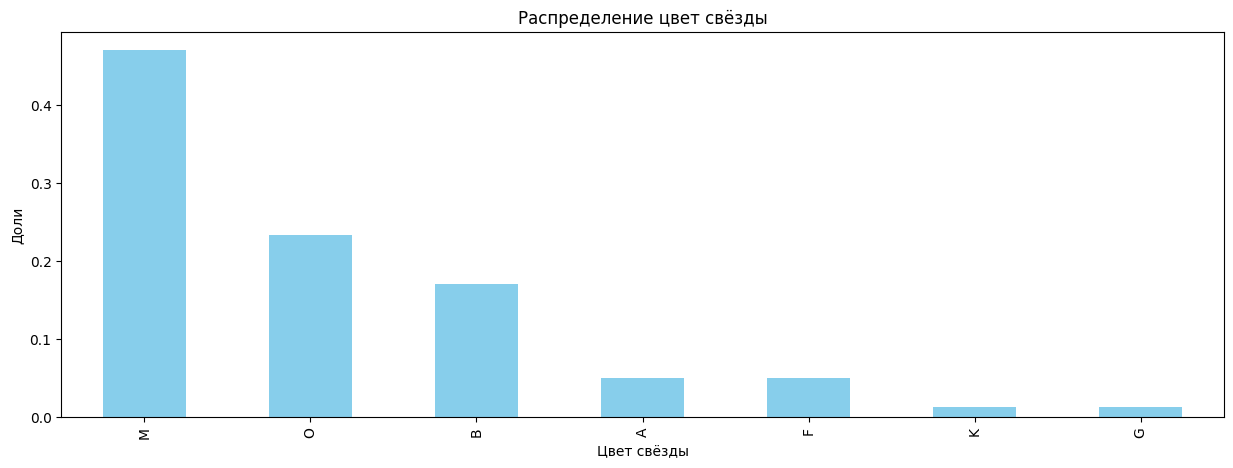

In [32]:
fig, axes = plt.subplots(figsize=(15, 5))
    
df['star_color'].value_counts(normalize=True).plot.bar(color=['skyblue']);

axes.set_title(f'Распределение цвет свёзды');
    
axes.set_xlabel('Цвет свёзды');
axes.set_ylabel('Доли');

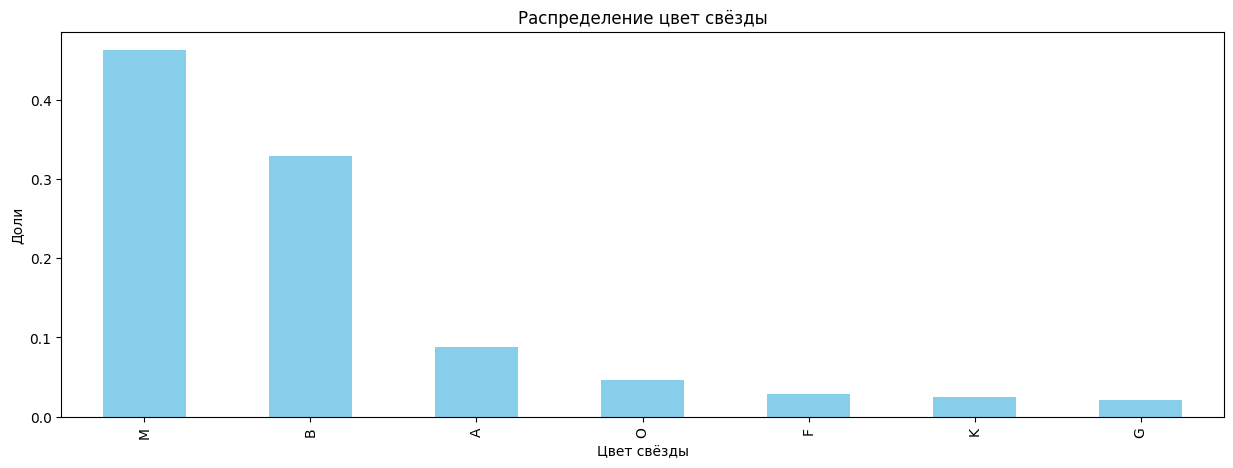

In [33]:
fig, axes = plt.subplots(figsize=(15, 5))
    
df['star_color_real'].value_counts(normalize=True).plot.bar(color=['skyblue']);

axes.set_title(f'Распределение цвет свёзды');
    
axes.set_xlabel('Цвет свёзды');
axes.set_ylabel('Доли');

Самый представленный цвет – красный. Но мы видим проблему с нашими цветами. Сегмент O предназначен для представления только звезд с температурой выше 33000 К, и тогда его не должно быть так много представлено, но здесь в нашем кадре данных сегмент O является вторым по популярности, что нереально, если мы посмотрим на их температуру.

В космосе, фактически около 3% относятся к спектральному классу O сине-фиолетового цвета, а около 0,13% — к спектральному классу B сине-белого цвета, и ласс М составляет около 90%.

## Коррелациа

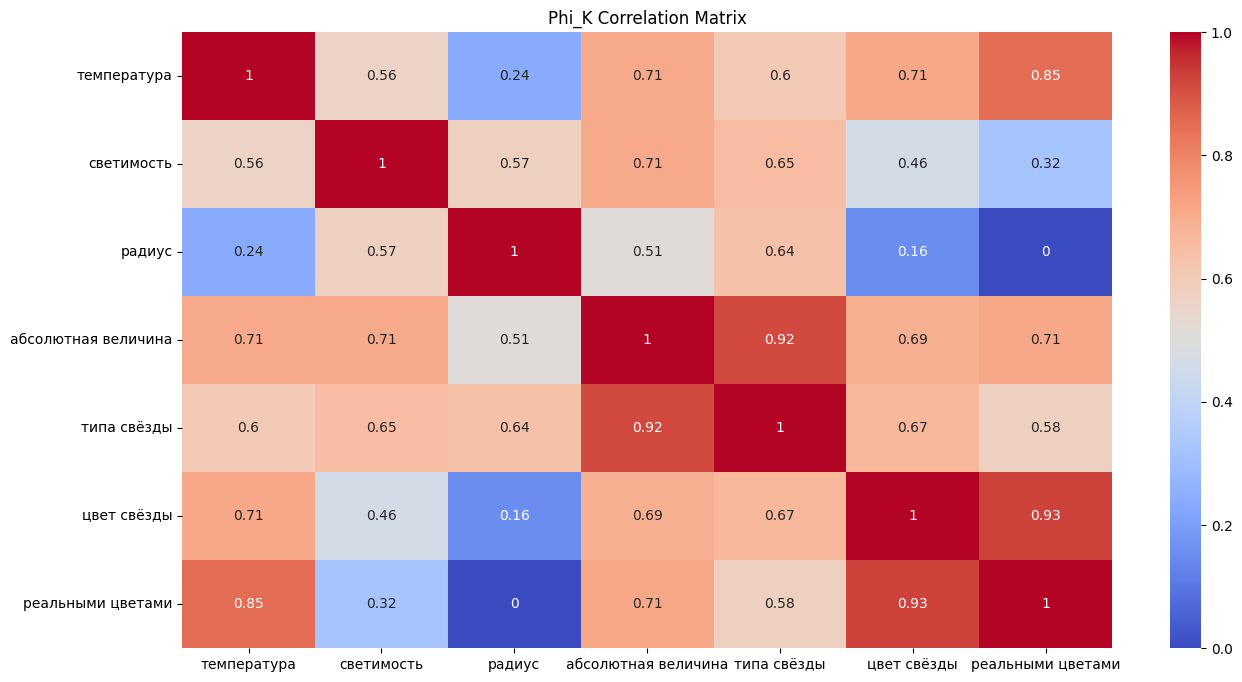

In [34]:
# Вычисляем матрицу корреляции с использованием phik
interval_cols = col_num
corr_matrix = df.phik_matrix(interval_cols=interval_cols)

cols_name = ['температура', 'светимость','радиус', 'абсолютная величина', 'типа свёзды', 'цвет свёзды',\
             'реальными цветами']

# Визуализация матрицы 
plt.figure(figsize=(15, 8))
sns.heatmap(corr_matrix, 
            xticklabels=cols_name,
            yticklabels=cols_name,
            annot=True, 
            cmap='coolwarm');
plt.title('Phi_K Correlation Matrix')
plt.show()

Мы видим, что коэффициент корреляции между температурой и реальным цветом более важен, чем с цветом нашего кадра данных (0,71 против 0,84), и это наиболее влиятельная функция с абсолютной величиной нашей целевой переменной.
Наименее влияющей на цель характеристикой является радиус. 
Никакой корреляции между признаками нет. Существует корреляция между реальным цветом и цветом, предоставленным данными, но мы собираемся сохранить только один из них для нашего исследования.

## Влияние выбросов на нейронную сеть

Мы увидели, что у нас слишком много звезд в группе О, звезд, температура которых должна быть выше 33000 К, но многие из них находятся ниже этого уровня температуры.

In [35]:
q1_t = df_stat.loc['25%', 'temperature_K']
q3_t = df_stat.loc['75%', 'temperature_K']
iqr_t = q3_t - q1_t

In [36]:
sup_out = q3_t+iqr_t*1.5
print('Выбросы – это звезды с эффективной температурой выше', sup_out)

Выбросы – это звезды с эффективной температурой выше 32622.375


In [37]:
len(df.query('temperature_K > @sup_out'))

11

In [38]:
len(df.query('temperature_K > @sup_out'))/len(df)

0.04583333333333333

In [39]:
df.query('temperature_K > @sup_out')['star_color'].value_counts()

star_color
O    11
Name: count, dtype: int64

In [40]:
df_real = df.copy()

In [41]:
df_outliers = df.copy()

In [42]:
df = df.drop('star_color_real', axis=1)

In [43]:
df_outliers = df_outliers.drop('star_color_real', axis=1)

In [44]:
df = df.query('temperature_K < @sup_out')

Свезды, температура которых превышает 33 000 К, являются выбросами. Поскольку у нас есть много звезд этой группы, которые имеют очень низкую температуру, 
Возможно, нам придется избавиться от выбросов. Действительно, поскольку таких звезд с высокой температурой только 11, нам нужно избавиться от них, чтобы получить подходящую температуру для остальных звезд. 
Давайте создадим фрейм данных с этими выбросами и сравним с другими моделями.

In [45]:
df_real = df_real.drop('star_color', axis=1)
df_real = df_real.rename(columns={'star_color_real': 'star_color'})

Однако мы собираемся сохранить выбросы для нашего второго кадра данных с «настоящими» цветами, поскольку выбросы будут соответствовать звездам из группы O. Возможно, эта модель лучше работает с выбросами.

## Вывод

Мы увидели, что половина объектов датафрейма были меньше Солнца, менее светящиеся чем у Солнца и их температура уступала температуре Солнца.

У нас есть выбросы по всем числовым характеристикам, кроме абсолютной величины. У нас есть 11 выбросов для температур, которые составляют около 4,6% датафрейма, и все они представляют собой голубые звезды.

Как и в предыдущей части, мы также увидели, что данние может содержать слишком много синих звезд, а некоторые из них могут быть голубовато-белыми звездами.

Мы также увидели, что возможная неправильная классификация цвета звезд снижает коэффициент корреляции с температурой. Мы также замечаем, что размер звезды не слишком сильно влиял на температуру. Когда речь идет до физических характеристик звезды, известно, что чем больше масса, тем выше будет температура, однако масса данных не указана, поскольку ее трудно измерить. Вот почему у красных гигантов может быть низкая температура из-за их малой массы.

В следующих частях мы построим и оценим нейронную сеть, используя три разны датафреймы, чтобы увидеть, насколько чувствительна нейронная сеть к цвету звезд. Эти датафреймы будут:
- датафрейм с цветами, предоставленными данными («star_color»)
- датафрейм с цветами, предоставленными данными («star_color») и без выбросов
- датафрейм с наиболее вероятными цветами («star_color_real»)

# Подготовка данных к построению модели

## Разделение данных

In [46]:
# Color from data
X = df.drop('temperature_K', axis=1)
y = df['temperature_K']
X_train, X_test, y_train, y_test = train_test_split(X, y, shuffle=True, random_state=42, test_size=0.25)

In [47]:
# Color from data w outliers
X_o = df_outliers.drop('temperature_K', axis=1)
y_o = df_outliers['temperature_K']
X_train_o, X_test_o, y_train_o, y_test_o = train_test_split(X_o, y_o, shuffle=True, \
                                                            random_state=42, test_size=0.25)

In [48]:
# Real color
X_real = df_real.drop('temperature_K', axis=1)
y_real = df_real['temperature_K']
X_train_real, X_test_real, y_train_real, y_test_real = train_test_split(X_real, y_real, shuffle=True, \
                                                                        random_state=42, test_size=0.25)

## Preprocessing pipeline

In [49]:
# Давайте извлечем категориальный признак и числовой признак
cat_col = X.select_dtypes(include='object').columns
num_col = X.select_dtypes(exclude='object').columns


# Наш кодер и масштабатор
ohe = OneHotEncoder(drop='first', handle_unknown='ignore')
scaler = StandardScaler()

# Кодирование
cat_pipe = Pipeline([
    ('enc', ohe)
])

# Масштабирование
num_pipe = Pipeline([
    ('num', scaler)
])

# создаём общий пайплайн для подготовки данных
data_preprocessor = ColumnTransformer(
    [
     ('enc', cat_pipe, cat_col),
     ('num', num_pipe, num_col)
    ], 
    remainder='passthrough'
)

## Преобразование датафреймых

In [50]:
# Data with misclassified color
X_train_ = data_preprocessor.fit_transform(X_train, y_train)
X_test_ = data_preprocessor.transform(X_test)

In [51]:
# Data with outliers
X_train_ot = data_preprocessor.fit_transform(X_train_o, y_train_o)
X_test_ot = data_preprocessor.transform(X_test_o)

In [52]:
# Data with real color
X_train_realt = data_preprocessor.fit_transform(X_train_real, y_train_real)
X_test_realt = data_preprocessor.transform(X_test_real)

# Построение базовой нейронной сети

## Преобразование в тензор

In [53]:
# Tensors with feature star_color
X_train_t = torch.from_numpy(X_train_).float()
X_test_t = torch.from_numpy(X_test_).float()
y_train_t = torch.FloatTensor(y_train.values)
y_test_t = torch.FloatTensor(y_test.values)

In [54]:
# Tensors with feature star_color and with outliers
X_train_t_o = torch.from_numpy(X_train_ot).float()
X_test_t_o = torch.from_numpy(X_test_ot).float()
y_train_t_o = torch.FloatTensor(y_train_o.values)
y_test_t_o = torch.FloatTensor(y_test_o.values)

In [55]:
# Tensors with feature star_color_real
X_train_t_real = torch.from_numpy(X_train_realt).float()
X_test_t_real = torch.from_numpy(X_test_realt).float()
y_train_t_real = torch.FloatTensor(y_train_real.values)
y_test_t_real = torch.FloatTensor(y_test_real.values)

## Класс нейронной сети

In [56]:
def create_layer(neurons_config):
    for i in range(1, len(n_neurons[j]) - 1):
        net_layers.append(nn.Linear(n_neurons[j][i-1], n_neurons[j][i]))
        if (i+1) % 2 == 0:
            net_layers.append(nn.ReLU()) 
        else:
            net_layers.append(nn.ReLU()) 

    net_layers.append(nn.Linear(n_neurons[j][-2], n_neurons[j][-1])) 
 
        
    net = nn.Sequential(*net_layers) 
        
    return net

## Инициализация веса

In [57]:
# Function to initialize the weights
def init_weights(layer):
    if type(layer) == nn.Linear: # Проверка, что слой – полносвязный
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu') 

## Функция обучения

In [58]:
# Function to train and evaluate the network
def train_eval_net(init_weights, optimizer, loss_metric, num_epochs, net, training_dataset, target_train, \
              test_dataset, target_test):
    net.apply(init_weights)
    

    for epoch in range(num_epochs):

    
        optimizer.zero_grad()

        preds = net.forward(training_dataset).flatten()

        loss_value = loss(preds, target_train)

        loss_value.backward()

        optimizer.step()

        if epoch % 10 == 0 or epoch == num_epochs - 1:
            loss_train = torch.sqrt(loss_value).item()
            net.eval()
            test_preds = net.forward(test_dataset).flatten()
            
            rmse_test = torch.sqrt(loss(test_preds, target_test)).item()
            print(f'Epoch {epoch+1}/{num_epochs} - Loss on training: {loss_train :.2f} - Loss on testing: {rmse_test}')
            loss_train_epochs.append(loss_train)
            rmse_test_epochs.append(rmse_test)
    return loss_train_epochs, rmse_test_epochs, test_preds

## Сравнение производительности нейронной сети

In [59]:
torch.manual_seed(1234)

n_in_neurons = X_train_.shape[1]
n_out_neurons = 1
n_neurons = [[n_in_neurons, n_out_neurons],  [n_in_neurons, 2*n_in_neurons, n_out_neurons], \
             [n_in_neurons, int(np.ceil(n_in_neurons*(2/3))), n_out_neurons],\
             [n_in_neurons, int(np.floor(n_in_neurons*(1/3))), n_out_neurons], \
             [n_in_neurons, int(np.ceil(n_in_neurons*(2/3))), int(np.floor(n_in_neurons*(1/3))), n_out_neurons],\
             [n_in_neurons, int(np.ceil(n_in_neurons*(3/4))), int(np.floor(n_in_neurons*(1/4))), n_out_neurons],\
             [n_in_neurons, int(np.ceil(n_in_neurons*(3/4))), int(np.floor(n_in_neurons*(2/3))), \
             int(np.ceil(n_in_neurons*(1/3))), n_out_neurons], [n_in_neurons, int(np.ceil(n_in_neurons*(3/4))), \
             int(np.floor(n_in_neurons*(2/3))),int(np.ceil(n_in_neurons*(1/3))), \
             int(np.floor(n_in_neurons*(1/4))), n_out_neurons]]

list_loss_train = []
list_rmse_test = []
list_preds = []

X_train_list = [X_train_t_o, X_train_t, X_train_t_real]
X_test_list = [X_test_t_o, X_test_t, X_test_t_real]
y_train_list = [y_train_t_o, y_train_t, y_train_t_real]
y_test_list = [y_test_t_o, y_test_t, y_test_t_real]

for k in range(0,3):
    for j in range(len(n_neurons)):
        net_layers = []
        loss_train_epochs = []
        rmse_test_epochs = []
        print(n_neurons[j])

        net = create_layer(n_neurons[j])

        optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)
        loss = nn.MSELoss()
        num_epochs = 1000


        (loss_train_epochs, rmse_test_epochs, test_preds) = train_eval_net(init_weights,
                                                                      optimizer, 
                                                                        loss, 
                                                                        num_epochs,
                                                                        net, 
                                                                        X_train_list[k],
                                                                        y_train_list[k],
                                                                        X_test_list[k],
                                                                        y_test_list[k]
                                                                        )
        print(X_train_list[k].shape)
        list_loss_train.append(loss_train_epochs)
        list_rmse_test.append(rmse_test_epochs)
        list_preds.append(test_preds)

[10, 1]
Epoch 1/1000 - Loss on training: 14027.49 - Loss on testing: 14626.5439453125
Epoch 11/1000 - Loss on training: 14025.16 - Loss on testing: 14623.9765625
Epoch 21/1000 - Loss on training: 14022.83 - Loss on testing: 14621.41015625
Epoch 31/1000 - Loss on training: 14020.50 - Loss on testing: 14618.845703125
Epoch 41/1000 - Loss on training: 14018.17 - Loss on testing: 14616.2841796875
Epoch 51/1000 - Loss on training: 14015.85 - Loss on testing: 14613.7216796875
Epoch 61/1000 - Loss on training: 14013.52 - Loss on testing: 14611.162109375
Epoch 71/1000 - Loss on training: 14011.20 - Loss on testing: 14608.603515625
Epoch 81/1000 - Loss on training: 14008.88 - Loss on testing: 14606.046875
Epoch 91/1000 - Loss on training: 14006.56 - Loss on testing: 14603.4921875
Epoch 101/1000 - Loss on training: 14004.24 - Loss on testing: 14600.9384765625
Epoch 111/1000 - Loss on training: 14001.92 - Loss on testing: 14598.38671875
Epoch 121/1000 - Loss on training: 13999.60 - Loss on testin

## Графики сходимости

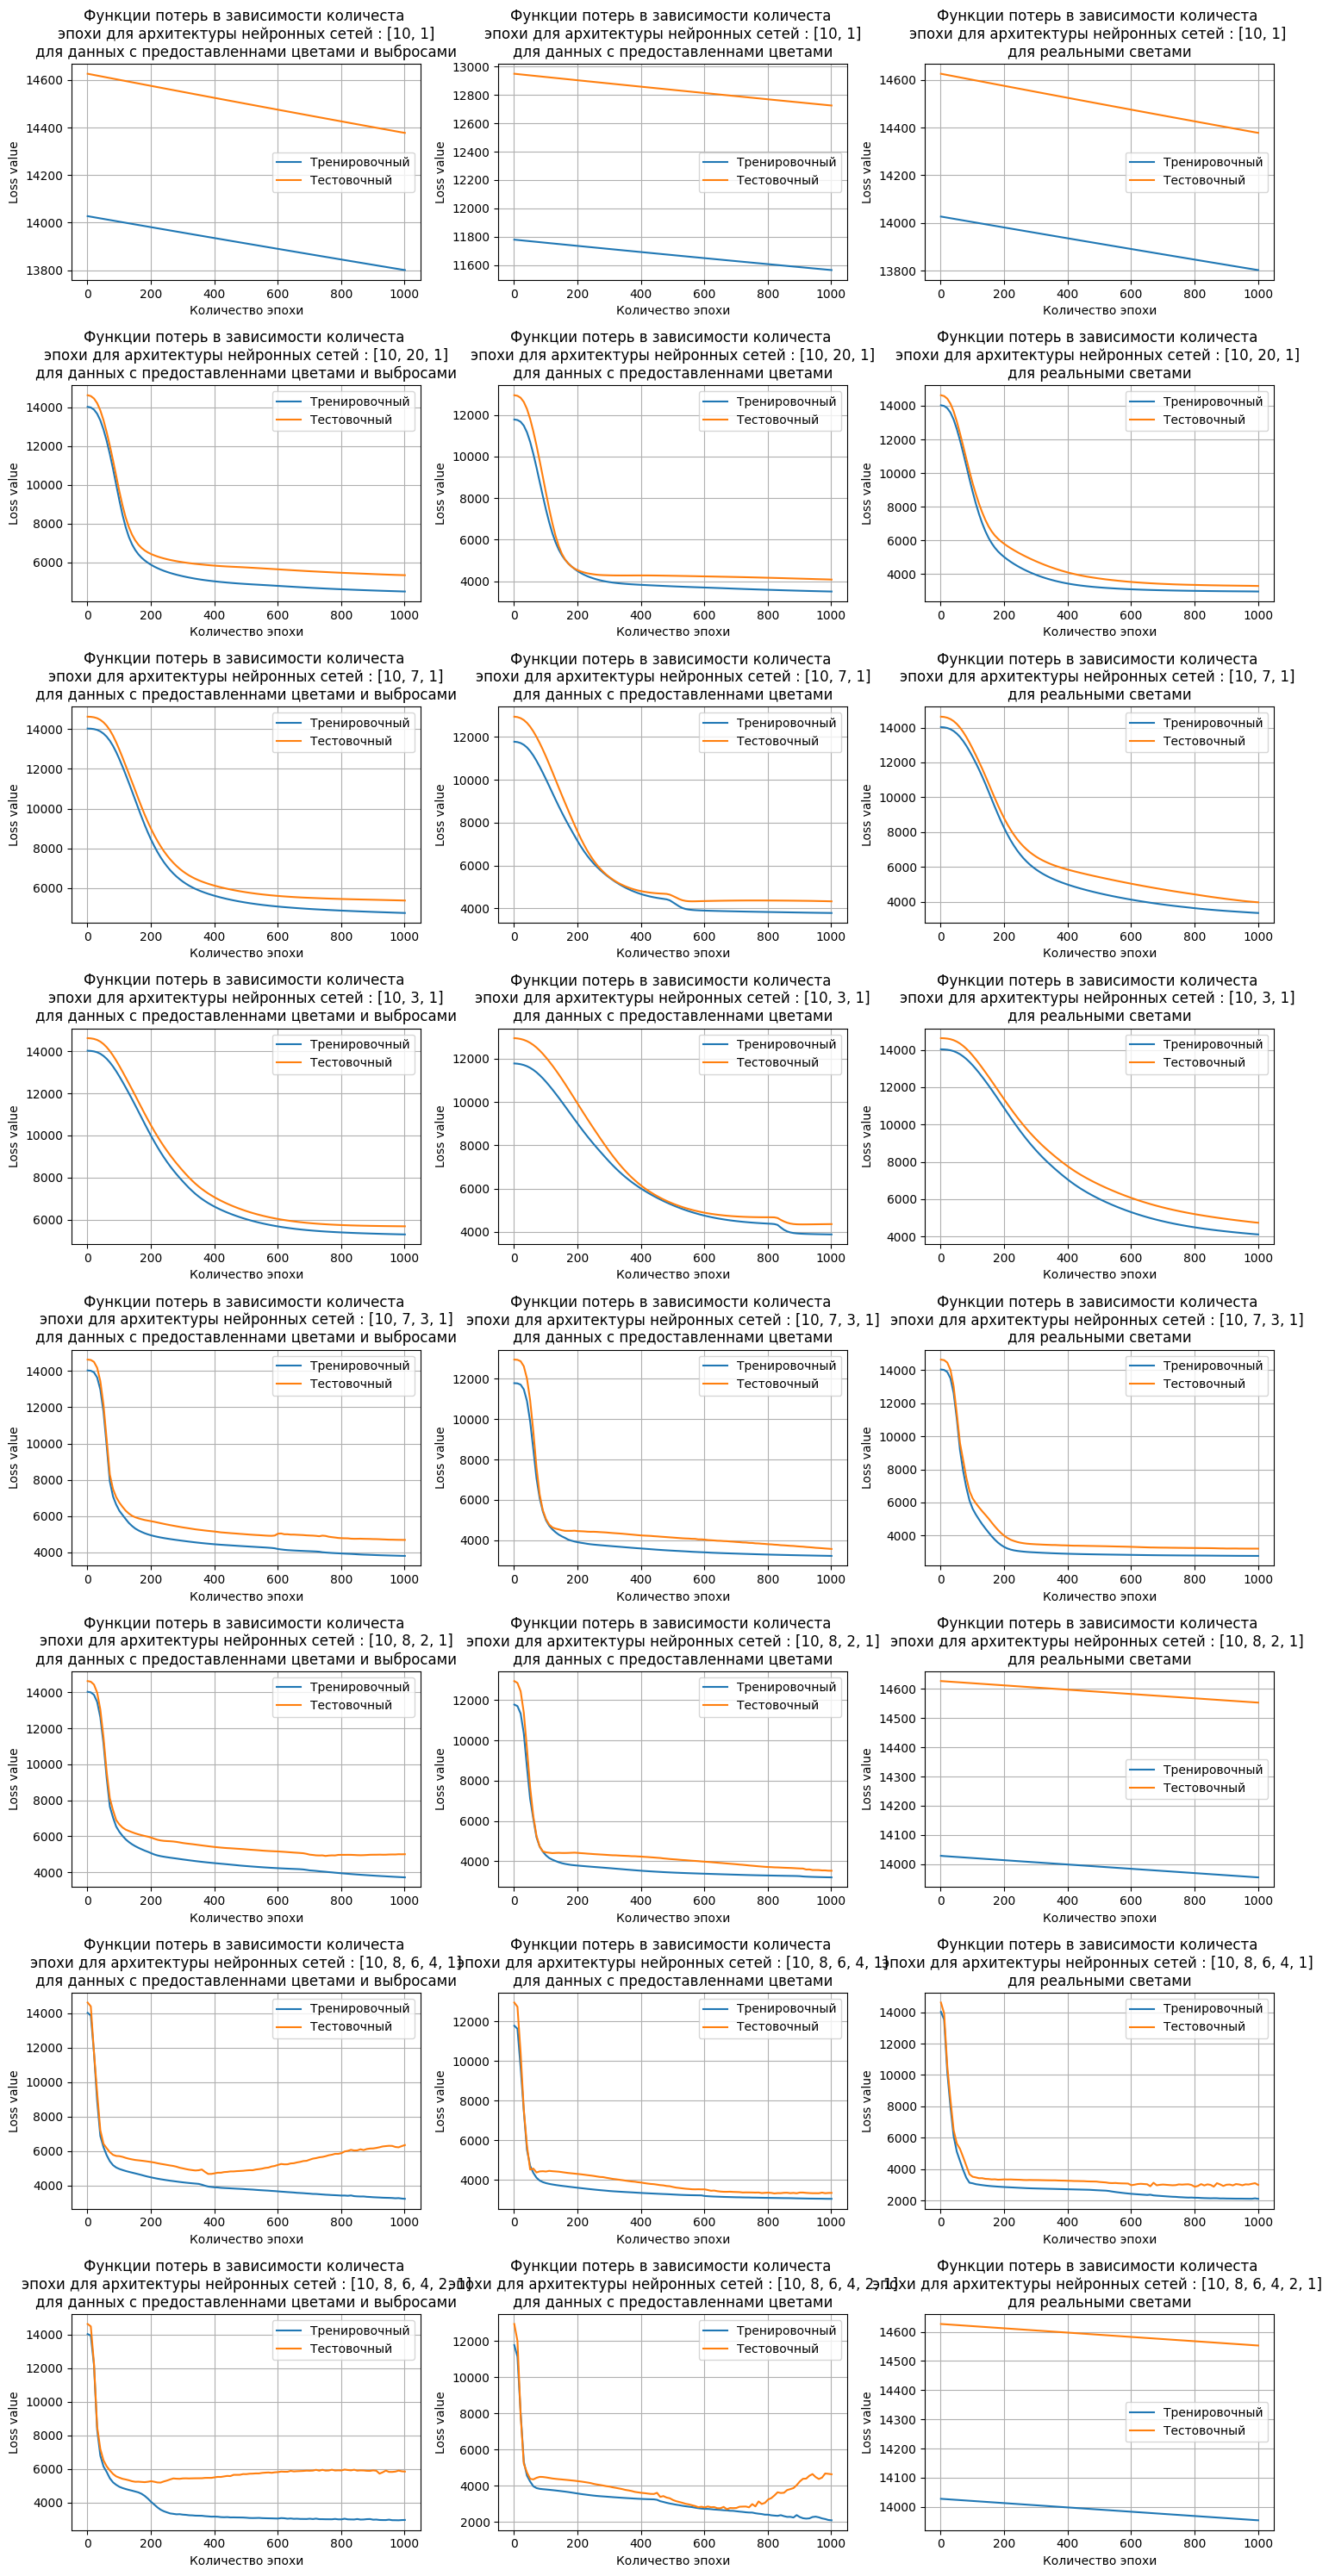

In [60]:
fig, axes = plt.subplots(nrows=8, ncols=3, figsize=(15, 30))

axes = axes.flatten()
epochs = [x for x in range(1, num_epochs+10, 10)]
dataframe_names = ['данные с предоставленным цветом и выбросами', 'данные с указанием цвета', \
                   'данные с реальным цветом']

for i in range(len(list_loss_train)):
    if i%3 == 0:
        sns.lineplot(x=epochs, y=list_loss_train[int(i/3)], label = 'Тренировочный', ax=axes[i]) 
        sns.lineplot(x=epochs, y=list_rmse_test[int(i/3)], label = 'Тестовочный', ax=axes[i]) 
        axes[i].set_title(f'Функции потерь в зависимости количеста \n'\
                       f'эпохи для архитектуры нейронных сетей : {n_neurons[int(i/3)]}\n'\
                       f'для данных с предоставленнами цветами и выбросами') 
    elif i%3 == 1:
        sns.lineplot(x=epochs, y=list_loss_train[int(i/3)+8], label = 'Тренировочный', ax=axes[i]) 
        sns.lineplot( x=epochs, y=list_rmse_test[int(i/3)+8], label = 'Тестовочный', ax=axes[i]) 
        axes[i].set_title(f'Функции потерь в зависимости количеста \n'\
                       f'эпохи для архитектуры нейронных сетей : {n_neurons[int(i/3)]}\n'\
                       f'для данных с предоставленнами цветами') 
    elif i%3 == 2:
        sns.lineplot(x=epochs, y=list_loss_train[int(i/3)+16], label = 'Тренировочный', ax=axes[i]) 
        sns.lineplot(x=epochs, y=list_rmse_test[int(i/3)+16], label = 'Тестовочный', ax=axes[i]) 
        axes[i].set_title(f'Функции потерь в зависимости количеста \n'\
                       f'эпохи для архитектуры нейронных сетей : {n_neurons[int(i/3)]} \n'\
                       f'для реальными светами') 
    

    axes[i].set_xlabel(f'Количество эпохи')
    axes[i].set_ylabel(f'Loss value')
    axes[i].grid()
    

plt.tight_layout()


plt.show()

Мы ясно видим, что среднеквадратическое отклонение у нас лучше при использовании реальны цвета, соответствующего температуре. Более того, в этом случае мы можем сохранить выбросы и при этом получить хорошие значения. 

Значение RMSE ухудшилось, когда мы использовали цвета, предоставленные данными, и нам пришлось избавиться от выбросов, чтобы улучшить наше RMSE (увеличение показателя RMSE на 2000 за счет удаления выбросов).

Мы видим, что наше лучшее распределение нейронной сети — 10, 8, 6, 4, 1. Благодаря этому распределению мы получаем хорошее среднеквадратическое отклонение, и даже если расчет не сходится, мы получаем что-то близкое к асимптоте.

Поскольку нам, вероятно, придется использовать предоставленные данные, нам нужно быть осторожными и остановить расчет до того, как данные будут переобучены. На кривой следует остановиться около 650.

##  График «Факт — Прогноз»

### Для данных с указанным цветом звезды

In [61]:
df_fig_1 = y_test.copy()

In [62]:
df_fig_1 = df_fig_1.to_frame()

In [63]:
df_fig_1.insert(1, "predictions_1", list_preds[14].tolist(), True)

In [64]:
df_fig_1.head()

,temperature_K,predictions_1
224,16787,15984.379883
68,2774,2874.630615
9,2700,3154.784668
199,3463,2907.497803
15,3340,3207.142822


In [65]:
rmse_1 = np.sqrt(mean_squared_error(df_fig_1['temperature_K'], df_fig_1['predictions_1']))
print(f'RMSE: {rmse_1:.2f}')

RMSE: 3354.61


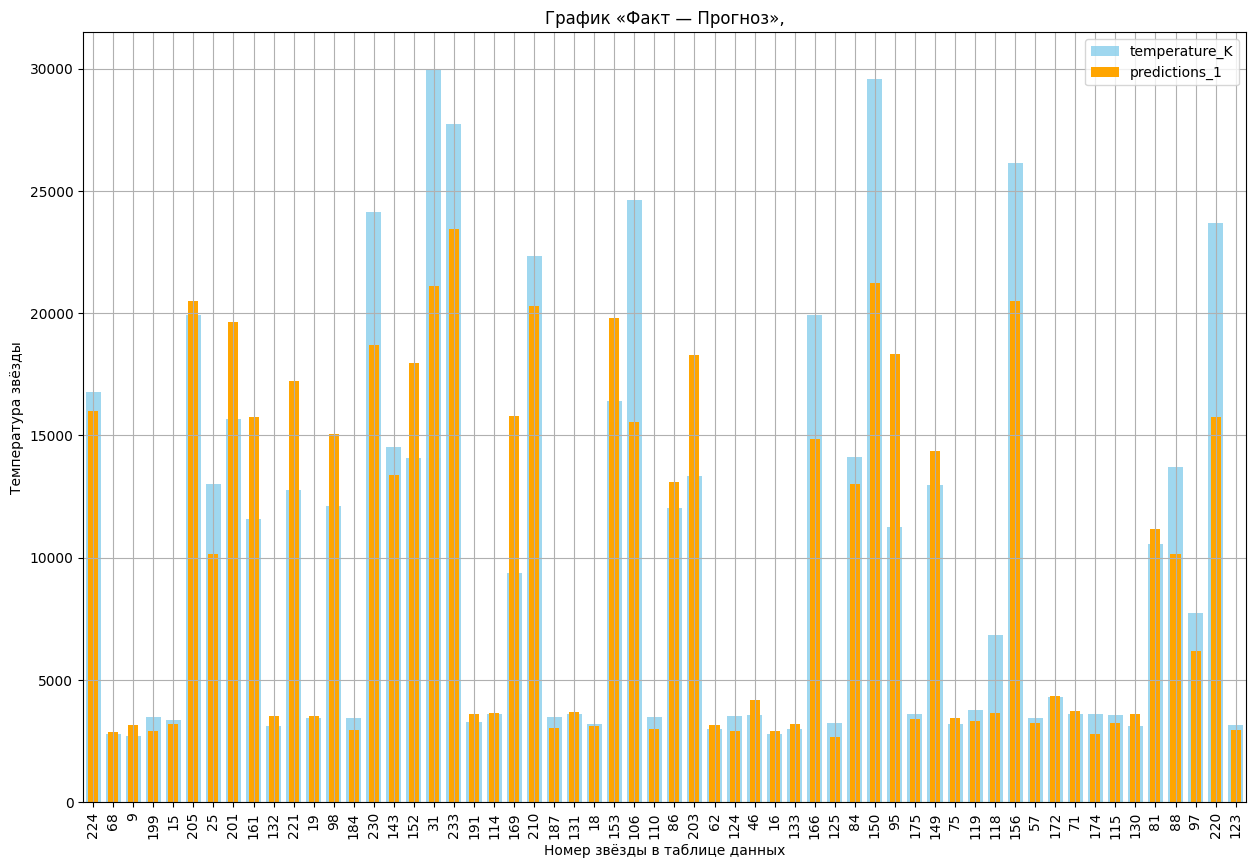

In [66]:
fig, ax = plt.subplots(figsize=(15,10))

ax = df_fig_1['temperature_K'].plot(kind='bar', color='skyblue', width=.75, legend=True, alpha=0.8)
df_fig_1['predictions_1'].plot(kind='bar', color='orange', width=.5, alpha=1, legend=True);

ax.set_title(f'График «Факт — Прогноз»,') 
ax.set_xlabel(f'Номер звёзды в таблице данных')
ax.set_ylabel(f'Температура звёзды')
ax.grid()

Заметим что чем выше температура, тем выше будет ошибка.

### Для данных с наиболее вероятным цветом

In [67]:
df_fig_2 = y_test_real.copy()

In [68]:
df_fig_2 = df_fig_2.to_frame()

In [69]:
df_fig_2.insert(1, "predictions_real", list_preds[22].tolist(), True)

In [70]:
rmse_2 = np.sqrt(mean_squared_error(df_fig_2['temperature_K'], df_fig_2['predictions_real']))
print(f'RMSE: {rmse_2:.2f}')

RMSE: 2989.10


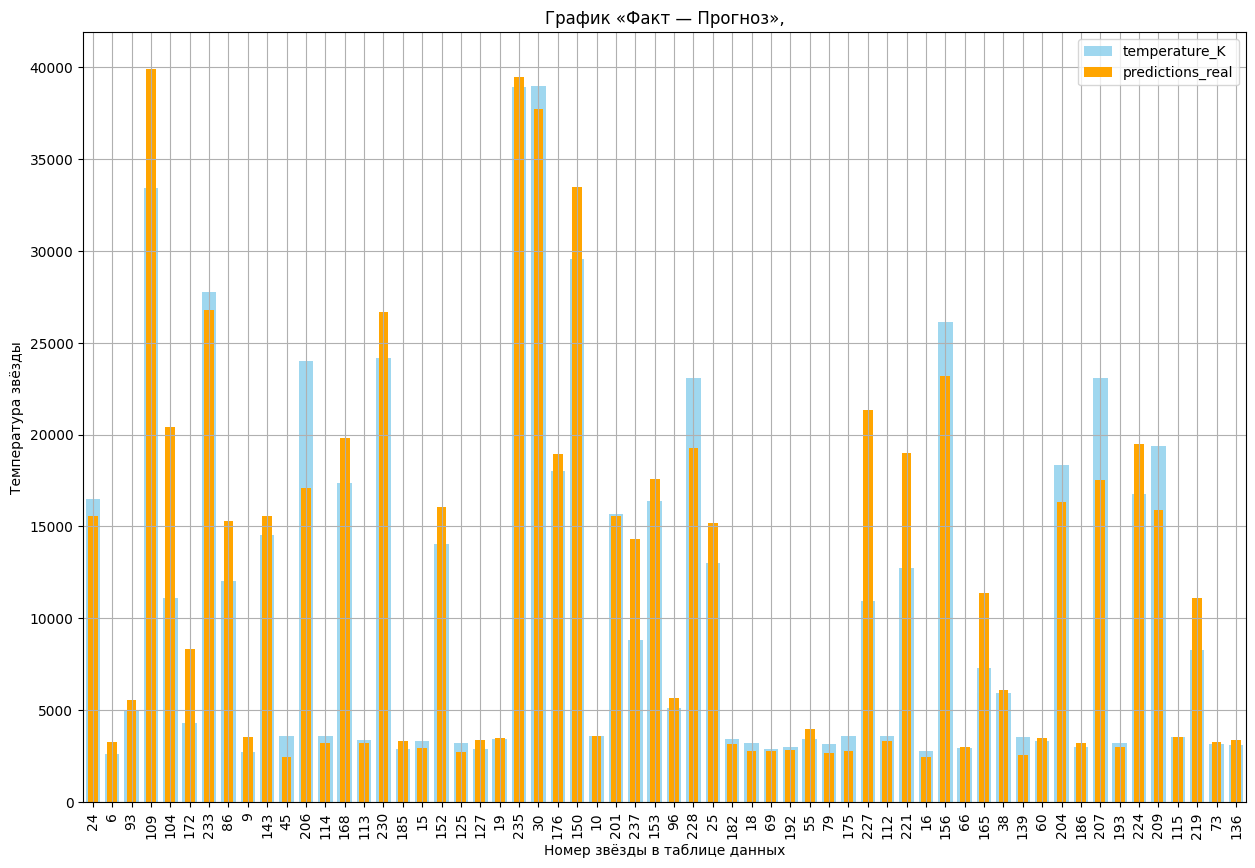

In [71]:
fig, ax = plt.subplots(figsize=(15,10))

ax = df_fig_2['temperature_K'].plot(kind='bar', color='skyblue', width=.75, legend=True, alpha=0.8)
df_fig_2['predictions_real'].plot(kind='bar', color='orange', width=.5, alpha=1, legend=True);

ax.set_title(f'График «Факт — Прогноз»,') 
ax.set_xlabel(f'Номер звёзды в таблице данных')
ax.set_ylabel(f'Температура звёзды')
ax.grid()

Мы ясно видим, что благодаря реальному цвету нейронная сеть способна лучше предсказывать высокую температуру. Однако для следующей части мы возьмем цвета, предоставленные данными.

# Улучшение нейронной сети

## Модификация базовой нейронной сети

In [72]:
class NeuralNet(nn.Module):
    def __init__(self, n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons):
        super(NeuralNet, self).__init__()
        self.fc1 = nn.Linear(n_in_neurons, n_hidden_neurons_1) 
        self.dp1 = nn.Dropout(p=0.75)
        self.relu = nn.ReLU()
        self.fc2 = nn.Linear(n_hidden_neurons_1, n_hidden_neurons_2) 
        self.dp2 = nn.Dropout(p=0.75)
        self.relu_2 = nn.ReLU()
        self.fc3 = nn.Linear(n_hidden_neurons_2, n_hidden_neurons_3) 
        self.dp3 = nn.Dropout(p=0.75)
        self.relu_3 = nn.ReLU()
        self.fc4 = nn.Linear(n_hidden_neurons_3, n_out_neurons)  
    
    def forward(self, x):
        out = self.fc1(x)
        out = self.dp1(out)
        out = self.relu(out)
        out = self.fc2(out)
        out = self.dp2(out)
        out = self.relu_2(out)
        out = self.fc3(out)
        out = self.dp3(out)
        out = self.relu_3(out)
        out = self.fc4(out)
        return out
    
n_in_neurons = X_train_.shape[1]
n_hidden_neurons_1 = 8
n_hidden_neurons_2 = 6
n_hidden_neurons_3 = 4
n_out_neurons = 1
    
net = NeuralNet(n_in_neurons, n_hidden_neurons_1, n_hidden_neurons_2, n_hidden_neurons_3, n_out_neurons)

In [73]:
def init_weights(layer):
    if type(layer) == nn.Linear: 
        nn.init.kaiming_uniform_(layer.weight, mode='fan_in', nonlinearity='relu') # for linear regression

net.apply(init_weights)

NeuralNet(
  (fc1): Linear(in_features=10, out_features=8, bias=True)
  (dp1): Dropout(p=0.75, inplace=False)
  (relu): ReLU()
  (fc2): Linear(in_features=8, out_features=6, bias=True)
  (dp2): Dropout(p=0.75, inplace=False)
  (relu_2): ReLU()
  (fc3): Linear(in_features=6, out_features=4, bias=True)
  (dp3): Dropout(p=0.75, inplace=False)
  (relu_3): ReLU()
  (fc4): Linear(in_features=4, out_features=1, bias=True)
)

In [74]:
class EarlyStopping:
    def __init__(self, patience=5, delta=0):
        self.patience = patience
        self.delta = delta
        self.best_score = None
        self.early_stop = False
        self.counter = 0
        self.best_model_state = None

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.best_model_state = model.state_dict()
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.best_model_state = model.state_dict()
            self.counter = 0

    def load_best_model(self, model):
        model.load_state_dict(self.best_model_state)

In [75]:
optimizer = torch.optim.Adam(net.parameters(), lr=1e-1)

loss = nn.MSELoss()


batch_size = 500

num_epochs = 1000

num_batches = ceil(len(X_train_t)/batch_size)

In [76]:
# Early stopping
early_stopping = EarlyStopping(patience=5, delta=0.01)

loss_train_epochs_2 = []
rmse_test_epochs_2 = []
preds_2 = []


for epoch in range(num_epochs):
    
    order = np.random.permutation(len(X_train_t))

    for batch_idx in range(num_batches):
        start_index = batch_idx * batch_size
        optimizer.zero_grad()
        
         # получение индексов текущего батча
        batch_indexes = order[start_index:start_index+batch_size]
        X_batch = X_train_t[batch_indexes]
        y_batch = y_train_t[batch_indexes]   
    

    preds = net.forward(X_train_t).flatten()

    loss_value = loss(preds, y_train_t)
        

    loss_value.backward()

    optimizer.step()
    
    early_stopping(loss_value, net)
    if early_stopping.early_stop:
        print("Early stopping")
        break

    if epoch % 10 == 0 or epoch == num_epochs - 1:
        loss_train = torch.sqrt(loss_value).item()
        
        net.eval()
        test_preds = net.forward(X_test_t).flatten()
            
        rmse_test = torch.sqrt(loss(test_preds, y_test_t)).item()
        print(f'Epoch {epoch+1}/{num_epochs} - Loss on training: {loss_train :.2f} - '\
              f'Loss on testing: {rmse_test}')
        loss_train_epochs_2.append(loss_train)
        rmse_test_epochs_2.append(rmse_test)
        

# Load the best model
early_stopping.load_best_model(net)
epoch_stopped = epoch-1
print('Epoch when the calculation stopped:', epoch_stopped)
        
preds_2.append(test_preds)

Epoch 1/1000 - Loss on training: 11776.73 - Loss on testing: 12944.34375
Epoch 11/1000 - Loss on training: 11340.38 - Loss on testing: 12345.1318359375
Epoch 21/1000 - Loss on training: 7789.67 - Loss on testing: 8412.96484375
Epoch 31/1000 - Loss on training: 5932.00 - Loss on testing: 6225.40771484375
Epoch 41/1000 - Loss on training: 4764.64 - Loss on testing: 4493.26318359375
Epoch 51/1000 - Loss on training: 4408.74 - Loss on testing: 4620.8154296875
Epoch 61/1000 - Loss on training: 4142.31 - Loss on testing: 4376.10498046875
Epoch 71/1000 - Loss on training: 3946.84 - Loss on testing: 4450.779296875
Epoch 81/1000 - Loss on training: 3862.83 - Loss on testing: 4463.22900390625
Epoch 91/1000 - Loss on training: 3816.11 - Loss on testing: 4451.45361328125
Epoch 101/1000 - Loss on training: 3788.18 - Loss on testing: 4477.93212890625
Epoch 111/1000 - Loss on training: 3764.08 - Loss on testing: 4455.5498046875
Epoch 121/1000 - Loss on training: 3739.19 - Loss on testing: 4422.080078

## График сходимости

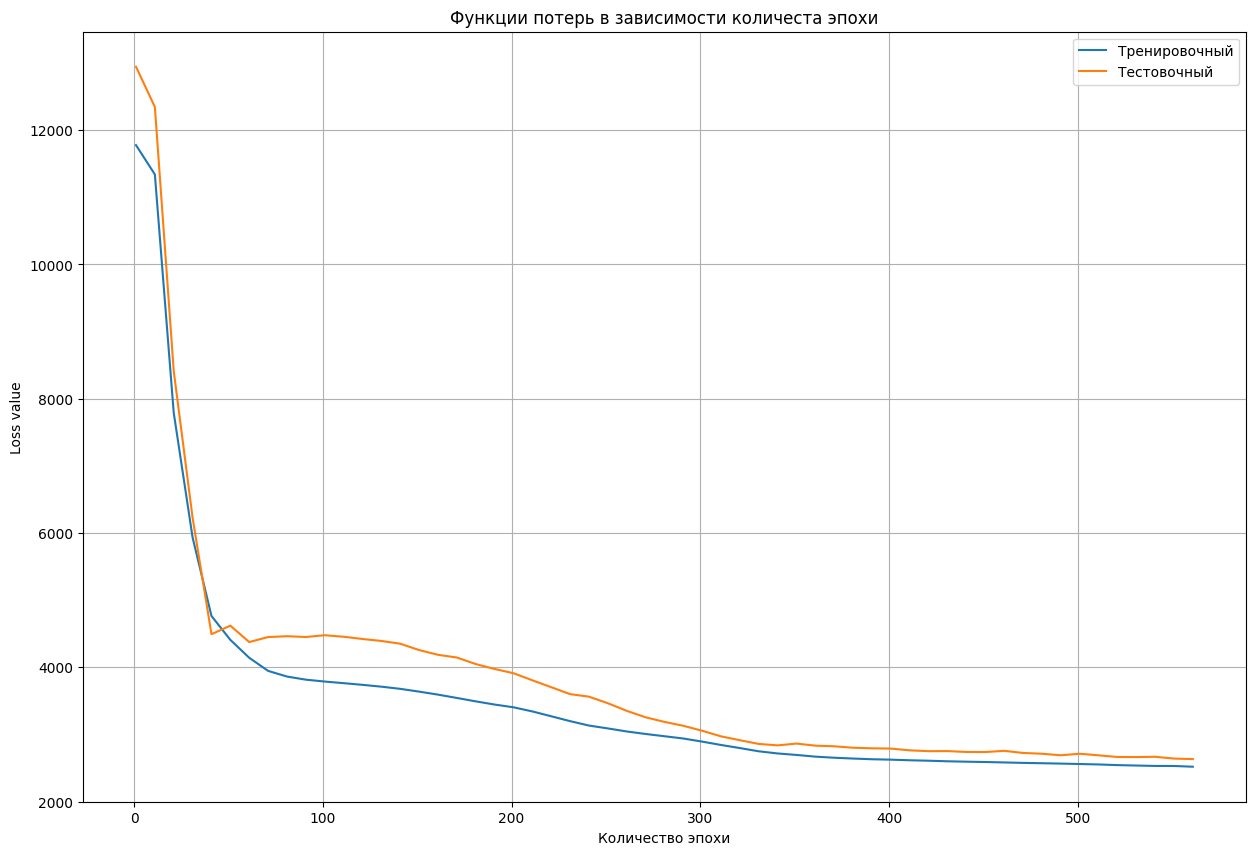

In [77]:
fig, ax = plt.subplots(figsize=(15,10))
epochs_2 = [x for x in range(1, epoch_stopped+10, 10)]
sns.lineplot(x=epochs_2[:-1], y=loss_train_epochs_2, label = 'Тренировочный', ax=ax) 
sns.lineplot(x=epochs_2[:-1], y=rmse_test_epochs_2, label = 'Тестовочный', ax=ax) 
    
ax.set_title(f'Функции потерь в зависимости количеста эпохи') 
ax.set_xlabel(f'Количество эпохи')
ax.set_ylabel(f'Loss value')
ax.grid()

Мы видим, что наша нейронная сеть слегка переобучена.

## RMSE 

In [78]:
net.eval()
with torch.no_grad():
    test_outputs = net.forward(X_test_t).flatten()
    test_loss = torch.sqrt(loss(test_outputs, y_test_t))
    print(f'Test Loss : {test_loss.item():.2f}')

Test Loss : 2634.09


Использование early-stopping и исключения трех слоев dropout улучшило наше RMSE в тестовом наборе данных.

##  График «Факт — Прогноз»

In [79]:
df_fig_1.insert(2, "predictions_2", preds_2[0].tolist(), True)

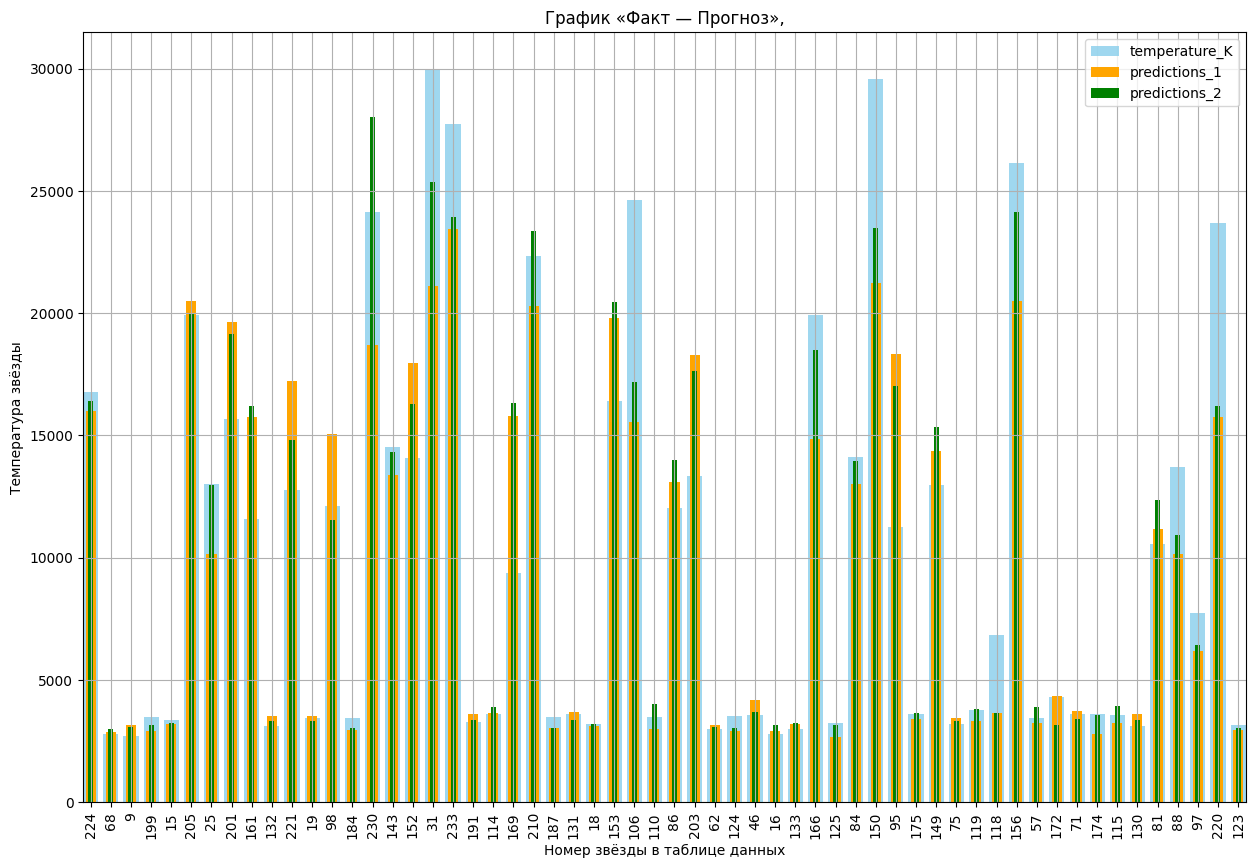

In [80]:
fig, ax = plt.subplots(figsize=(15,10))

ax = df_fig_1['temperature_K'].plot(kind='bar', color='skyblue', width=.75, legend=True, alpha=0.8)
df_fig_1['predictions_1'].plot(kind='bar', color='orange', width=.5, alpha=1, legend=True);
df_fig_1['predictions_2'].plot(kind='bar', color='green', width=.25, alpha=1, legend=True);

ax.set_title(f'График «Факт — Прогноз»,') 
ax.set_xlabel(f'Номер звёзды в таблице данных')
ax.set_ylabel(f'Температура звёзды')
ax.grid()

На графиках мы видим, что мы улучшили прогноз некоторых высоких температур.

# Общие выводы

Предоставленный фрейм данных не содержал ни пропущенных значений, ни явных дубликатов. 

Однако в столбце «star_color» были неочевидные дубликаты. Когда мы попытались исправить названия категорий в этом столбце, используя Гарвардскую классификацию, мы заметили, что некоторые цвета звезд зашкаливают, в основном это голубые звезды с самой высокой температурой. Похоже, что 80% голубых звезд были неправильно классифицированы, и многие из них могли быть просто голубовато-белыми.
Поскольку на нейронную сеть могут влиять неправильно масштабированные данные, мы можем предположить, что если звезды с высокой температурой не будут хорошо классифицированы, наша модель может не дать хороших результатов. 
Кроме того, мы знаем, что температура сильно коррелирует с цветом звезд. Например, когда голубые звезды начинают остывать, они становятся белее.

Очень важно получить правильно цвет. Когда мы использовали правильный предполагаемый цвет для звезд, наша модель давала хорошее R?SE, и мы могли использовать выбросы. Когда мы использовали цвета, предоставленные данными, наша модель с выбросами не дала хорошего результата, и нам пришлось избавиться от них, чтобы получить хорошее RMSE. В итоге мы получили модель, пытающуюся предсказать высокую эффективную температуру. Чем выше температура, тем выше будет ошибка.

Чтобы улучшить модель с использованием цвета, предоставленного данными, мы использовали раннюю остановку, чтобы предотвратить переобучение, а также три слоя исключения. Модель смогла дать лучшие прогнозы, и в итоге мы получили RMSE 2849.